<a href="https://colab.research.google.com/github/georgeliu1998/keras_model_tuning/blob/master/keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building and Tuning a Neural Network Model Using Keras

Did you ever wonder which parameters are most impactful when it comes to neural networkings model tuning? I did. That's why I worked on this project. The goal was to develop intuition about neural network parameter tuning (including hyperparameter).

In this project, I use Keras to build a generic neural network class which can be used to test model performance. With the power of Colab GPU, building and tesing neural networks is a pleasure. So let's do this!

## Setting up the Environment

In [0]:
from numpy.random import seed
seed(6)

from tensorflow import set_random_seed
set_random_seed(6)

import numpy as np
seed = np.random.RandomState(6)

In [0]:
import pandas as pd
import sklearn
import pickle
from time import time
import importlib 
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

Using TensorFlow backend.


## Getting the Data

In [0]:
# Upload the Kaggle API credentials
from google.colab import files
files.upload()

In [0]:
# Install Kaggle API
!pip install -U -q kaggle

# Create a directory and copy over the API json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Limit access
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# Download the dataset
!kaggle datasets download -d uciml/pima-indians-diabetes-database

  0% 0.00/8.86k [00:00<?, ?B/s]
100% 8.86k/8.86k [00:00<00:00, 3.55MB/s]


In [0]:
pima = pd.read_csv('pima-indians-diabetes-database.zip')
print(pima.head())

# Get the features and labels as np arrays
X, y = pima.values[:, 0:8], pima.values[:, 8]
print(pima.shape, pima.shape)

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
(768, 9) (768, 9)


In [0]:
# Check percentage of both classes
pima['Outcome'].value_counts()/pima.shape[0]

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

## Getting a Baseline Result with XGBoost

In [0]:
# Get baseline accuracy using XGBoost
t1 = time()
clf = xgb.XGBClassifier()
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores = cross_val_score(clf, X, y, cv=cv)
t2 = time()
t = t2 - t1

print("Mean Accuracy: {:.2%}, Standard Deviation: {:.2%}".format(scores.mean(), scores.std()))
print("Time taken: {:.2f} seconds".format(t))

Mean Accuracy: 74.88%, Standard Deviation: 3.45%
Time taken: 0.35 seconds


In [0]:
# Let's test with data standardization:
std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(X)

scores = cross_val_score(clf, X_std, y, cv=cv)

print("Mean Accuracy: {:.2%}, Standard Deviation: {:.2%}".format(scores.mean(), scores.std()))

Mean Accuracy: 76.31%, Standard Deviation: 2.72%


## Building the Neural Network Class and Test Functions

In [0]:
class SequentialModel:
  """
  The base class for a Neural Networks model
  """
  
  def __init__(self, input_dim, num_layers, num_units, 
               activation, activation_out, 
               loss, initializer, optimizer, learning_rate, 
               epochs, batch_size, metrics=['accuracy'], one_hot=False):
    """
    Params:
      input_dim: int, number of features
      num_layers: int, number of layers of the model (excluding the input layer)
      num_units: list, number of units in each layer(excluding the input layer)
      activation: str, activation function used in all layers except output
      activation_out: str, activation function used in output layer
      loss: str, loss functon
      initializer: str, kernel initializer
      optimizer: str, optimizer
      metrics: list of strings, metrics used
      epochs: int, number of epochs to train for
      batch_size: int, number of samples per batch
      one_hot: bool, whether one hot encoding is needed
    """
    self.input_dim = input_dim
    self.num_layers = num_layers
    self.num_units = [num_units, 1]
    self.activation = activation
    self.activation_out = activation_out
    self.loss = loss
    self.initializer = initializer
    self.optimizer = optimizer
    self.learning_rate = learning_rate
    self.metrics = metrics
    self.epochs = epochs
    self.batch_size = batch_size
    self.one_hot = one_hot
    
    # Initialize the sequential model
    self.model = Sequential()

    
  def build_model(self):
    """
    Adds layers and compiles the model
    """
    # Ensure num_units list's length is the same as num_layers
    if self.num_layers != len(self.num_units):
      # Expand the list by repeating number of nodes except for last layer
      num_nodes, num_nodes_out = self.num_units[0], self.num_units[-1]
      self.num_units = [i for i in range(self.num_layers-1) for i in [num_nodes]]
      self.num_units.append(num_nodes_out) 
 
    # Loop thru all the layers
    for i in range(self.num_layers):
      # different layers should have different setups
      if i == 0: # input and first hidden layer
        self.model.add(Dense(units=self.num_units[i],
                             input_dim=self.input_dim,
                             kernel_initializer=self.initializer,
                             activation=self.activation)) 
      elif i+1 == self.num_layers: # output layer
        self.model.add(Dense(units=self.num_units[i],
                             kernel_initializer=self.initializer,
                             activation=self.activation_out))
      else: # hidden layers
        self.model.add(Dense(units=self.num_units[i],
                            kernel_initializer=self.initializer,
                            activation=self.activation))
    
    # Instantiate the optimizer class
    optimizer_class = getattr(importlib.import_module("keras.optimizers"), 
                             self.optimizer)
    self.optimizer = optimizer_class(lr=self.learning_rate)
    # Compile the model
    self.model.compile(loss=self.loss,
                       optimizer=self.optimizer,
                       metrics=self.metrics)
        
  
  def evaluate_model(self, X, y, n_splits=10):
    """
    Evaluates the model using cross-validation.
    
    Params:
      X: np.array, features
      y: np.array, labels
      n_splits: int, number of folds for the cross-validation
    Returns:
      mean_accuracy: float, the average accuracy based on the cross-validation.
    
    """
    score_lst = []
    t1 = time()
    
    print("Starting {}-fold cross-validation...".format(n_splits))
    
    kfold = StratifiedKFold(n_splits=n_splits, 
                            shuffle=True, 
                            random_state=seed)
    
    # Loop through the different folds
    for train_index, test_index in kfold.split(X, y):
      # Do one-hot encoding when needed
      if self.one_hot:
        y_one_hot = to_categorical(y)
      else:
        y_one_hot = y
        
      self.model.fit(X[train_index],
                     y_one_hot[train_index],
                     epochs=self.epochs,
                     batch_size=self.batch_size,
                     verbose=0)
        
      scores = self.model.evaluate(X[test_index],
                                   y_one_hot[test_index], 
                                   verbose=0)
            
      # The second item is accuracy
      score_lst.append(scores[1])

    t2 = time()
    t = t2 - t1
    # Convert time to mintues
    t /= 60

    print("Finished cross-valiation. Took {:.1f} mintues.".format(t))

    # Convert to np.array and calculate mean and sd
    score_lst = np.array(score_lst)
    mean_acc = score_lst.mean()
    sd_acc = score_lst.std()

    print("Mean Accuracy: {:.2%}, Standard Deviation: {:.2%}".format(mean_acc, sd_acc))
    return mean_acc

In [0]:
def get_defaults(input_dim=8, 
                 num_layers=2,
                 num_units=8,
                 activation='relu',
                 activation_out='sigmoid',
                 loss='binary_crossentropy',
                 initializer='random_uniform',
                 optimizer='adam',
                 learning_rate=0.001,
                 metrics=['accuracy'],
                 epochs=10, 
                 batch_size=4,
                 one_hot=False):
  """
  Returns a dict of default hyperparameter values  
  """

  defaults = {'input_dim': input_dim, 
              'num_layers': num_layers, 
              'num_units': num_units, 
              'activation': activation, 
              'activation_out': activation_out, 
              'loss': loss, 
              'initializer': initializer, 
              'optimizer': optimizer, 
              'learning_rate': learning_rate, 
              'metrics': metrics, 
              'epochs': epochs, 
              'batch_size': batch_size, 
              'one_hot': one_hot}
  
  return defaults


def get_tuning_options(**kwargs):
  """
  Defines tuning parameter and corresponding options
  
  Params:
    Keyword arguments - the key words can be any of the following:
      input_dim, num_layers, num_units, activation, activation_out, 
      loss, initializer, optimizer, learning_rate, epochs, batch_size, 
      metrics=['accuracy'], one_hot=False
  Returns:
    tuning_options: Python dict made up of the given keyword, argument pairs
  
  """ 
  tuning_options = {}
  
  for param, options in kwargs.items():
    tuning_options[param] = options 
  
  return tuning_options

In [0]:
def build_eval(X, y, param_dict):
  """
  Builds a Neural Network model using the given params and returns the 
  cross-validation accuracy
  
  Params:
    X: np.array, the features
    y: np.array, the labels
    param_dict: Python dict containing the tuning parameters and values
  
  Returns:
    result: float, percentage accuracy based on cross-validation
  """
  print("Building model using param_dict:\n {}".format(param_dict))
  
  model = SequentialModel(input_dim=param_dict['input_dim'], 
                          num_layers=param_dict['num_layers'], 
                          num_units=param_dict['num_units'],
                          activation=param_dict['activation'], 
                          activation_out=param_dict['activation_out'], 
                          loss=param_dict['loss'], 
                          initializer=param_dict['initializer'], 
                          optimizer=param_dict['optimizer'], 
                          learning_rate=param_dict['learning_rate'],
                          epochs=param_dict['epochs'], 
                          batch_size=param_dict['batch_size'])
  model.build_model()
  result = model.evaluate_model(X, y)
  
  return result


def run_test(X, y, param_dict, tuning_options=None):
  """
  Tests different parameter's accurcy using the given tuning options

  Params:
    X: np.array, the features
    y: np.array, the labels
    param_dict: Python dict containing the tuning parameters and values
    tuning_options: Python dict made up of the given keyword, argument pairs
  Returns:
    results: a dict when tuning_options is provided, otherwise a float that's the mean accuracy.

  """
  if tuning_options:
    results = {}
        
    for parameter, options in  tuning_options.items():
      results[parameter] = {}
      param_dict_temp = deepcopy(param_dict)
      
      for option in options:
        print("\nEvaluating parameter \"{}\" using value \"{}\"...".format(parameter, option))
        # Update the corresponding parameter
        param_dict_temp[parameter] = option
        
        try:
          #print("param_dict_temp: {}".format(param_dict_temp))
          results[parameter][option] = build_eval(X, y, param_dict_temp)
        except Exception as e: 
          results[parameter][option] = 'NaN'
          print('Error: {}, skipping...'.format(e))
          pass
    return results
  
  else:
    return build_eval(X, y, param_dict)

In [0]:
def wrangle_results(results):
    """
    Transforms the results dict into a df that's good for analysis.
    
    Params:
      results: dict, the results dict returned by the build_eval() function

    Returns:
        df_plot: pandas df, the wrangled long format dataframe
    """
    df = pd.DataFrame(results)
    # Get the col names as value vars for melt func
    value_vars = df.columns.tolist()
    # Reset index and rename the index col 
    df = df.reset_index().rename(columns={'index': 'option'})
    # Transform from wide to long format for easy plotting
    df_long = pd.melt(df, id_vars='option', value_vars=value_vars)
    df_long = df_long.rename(columns={'variable': 'parameter'})
    # Exclude the zero and null values
    df_long = df_long[~df_long['value'].isnull()]
    df_long = df_long.query("value!=0 & value!='NaN'")

    # Calculate the range and sd of each parameter group and convert to a df
    ranges = df_long.groupby('parameter').apply(lambda grp: grp.value.max() - grp.value.min())
    sd = df_long.groupby('parameter').apply(lambda grp: grp.value.std())
    spread = pd.concat([ranges, sd], axis=1).rename(columns={0: 'ranges', 1: 'sd'})
    # Join back the df
    df_spread = pd.merge(df_long, spread, how='left', left_on='parameter', right_index=True)
    # Reorder columns
    df_spread = df_spread[['parameter', 'option', 'value', 'ranges', 'sd']]
    # Remove the row with zero value
    df_spread = df_spread.query('ranges!=0')
    # Change column dtype
    df_spread['value'] = df_spread['value'].astype(float)
    # Sort the dataframe and use the resulting index to slice
    # This ensures the plot will be ordered accordingly
    idx = df_spread.sort_values(by=['ranges', 'option'], ascending=False).index
    df_plot = df_spread.loc[idx, :]
    
    return df_plot

  
def get_best_options(df):
  """
  Gets the best options for all params from the given results df
  
  Params:
    df: the results df returned by the wrangle_results() function
  
  Returns:
    best_options: a list of list containing param and value.
  
  """
  best_options = df.groupby('parameter').apply(lambda grp: grp.nlargest(1, 'value'))[['parameter', 'option']].values.tolist()
  
  return best_options  


def visualize_distribution(df, save_figure=False):
  """
  Visualizes the result distribution using boxplot and swarmplot
  
  Params:
    df: pandas df, the wrangled results df returned by the wrangle_results function
    save_figure: boolean, whether to save the figure or not
  """
  fig, ax = plt.subplots(figsize=(16, 12))
  df['value'] =  df['value'].astype(float)
  sns.boxplot(x='parameter', y='value', data=df, ax=ax)
  sns.swarmplot(x='parameter', y='value', data=df, size=12, ax=ax)
  ax.set_xlabel('Parameters',size=16)
  ax.set_ylabel('Values',size=16)
  fig_title = 'Parameter Tuning Results Distribution'
  ax.set_title(fig_title, y=1.05, fontsize=30)
  
  if save_figure:
    figure_name = '/content/gdrive/My Drive/' + fig_title + '.png'
    fig.savefig(figure_name)


def visualize_trend(df, save_figure=False):
  """
  Visualizes the result trend using line plot
  
  Params:
    df: pandas df, the wrangled results df returned by the wrangle_results function.
    save_figure: boolean, whether to save the figure or not.
  """
  fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(30, 12))
  axes = axes.flatten()
  # Get the parameter list
  params = df.parameter.unique().tolist()
  # Loop thru the axes
  for i, ax in enumerate(axes):
    try:
      # Each subplot corresponds to one parameter
      param = params[i]
      df_param = df.query("parameter==@param")
      df_param.plot(kind='line', x='option', y='value', ax=ax)
      # Log-transform the x-axis for learning rate to avoid mixing up
      if param == 'learning_rate':
        ax.set_xscale('log')
      # Set the x ticks and tick lables
      if param in ('initializer', 'optimizer'):
        ax.set_xticks(np.arange(5))
        ax.set_xticklabels(df_param.option)
      ax.set_xlabel(param, fontsize=16) 
      ax.set_ylabel('Accuracy', fontsize=16) 
      ax.get_legend().remove()
    except:
      # Remove the last axis since we have only 7 params
      fig.delaxes(ax)
  
  fig_title = 'Parameter Tuning Trend'
  fig.suptitle(fig_title, y=0.92, verticalalignment='bottom', fontsize=30)
  
  plt.show()
  
  if save_figure:
    figure_name = '/content/gdrive/My Drive/' + fig_title + '.png'
    fig.savefig(figure_name)


## Running the Test

In [0]:
# Get baseline accuracy using defauls with the defined Neural Networks class  
param_dict_defaults, param_dict = get_defaults(), get_defaults()
accuracy_baseline = run_test(X=X, y=y, param_dict=param_dict_defaults)

Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.001, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 4, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 1.5 mintues.
Mean Accuracy: 71.61%, Standard Deviation: 2.92%


In [0]:
# Get the tuning optioins
num_units = [4, 8, 16, 32, 64]
num_layers = [2, 4, 8, 16, 32]
loss = ['binary_crossentropy', 'categorical_crossentropy', 'sparse_categorical_crossentropy']
initializer = ['random_uniform', 'random_normal', 'TruncatedNormal', 'glorot_normal', 'glorot_uniform']
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1]
optimizer = ['adam', 'adamax', 'adagrad', 'sgd', 'rmsprop']
epochs = [5, 10, 20, 40, 80]
batch_size = [1, 2, 4, 8, 16]

tuning_options = get_tuning_options(num_units=num_units, 
                                    num_layers=num_layers, 
                                    loss=loss, 
                                    initializer=initializer,
                                    learning_rate=learning_rate, 
                                    optimizer=optimizer, 
                                    epochs=epochs, 
                                    batch_size=batch_size)

# Test all the tuning options
results = run_test(X=X, y=y, 
                   param_dict=param_dict_defaults,
                   tuning_options=tuning_options)

# Save the tuning results 
with open('/content/gdrive/My Drive/cross_validation_results.pkl', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)
    print("\nResults saved to Google Drive successfully!")


Evaluating parameter "num_units" using value "4"...
Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 4, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.001, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 4, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 1.5 mintues.
Mean Accuracy: 72.00%, Standard Deviation: 6.42%

Evaluating parameter "num_units" using value "8"...
Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.001, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 4, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 1.5 mintues.
Mean Accuracy: 72.26%, Standard Deviation: 4.39

In [0]:
# Load the pickled results dict
with open('/content/gdrive/My Drive/cross_validation_results.pkl', 'rb') as f:
    results = pickle.load(f)

df = wrangle_results(results)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


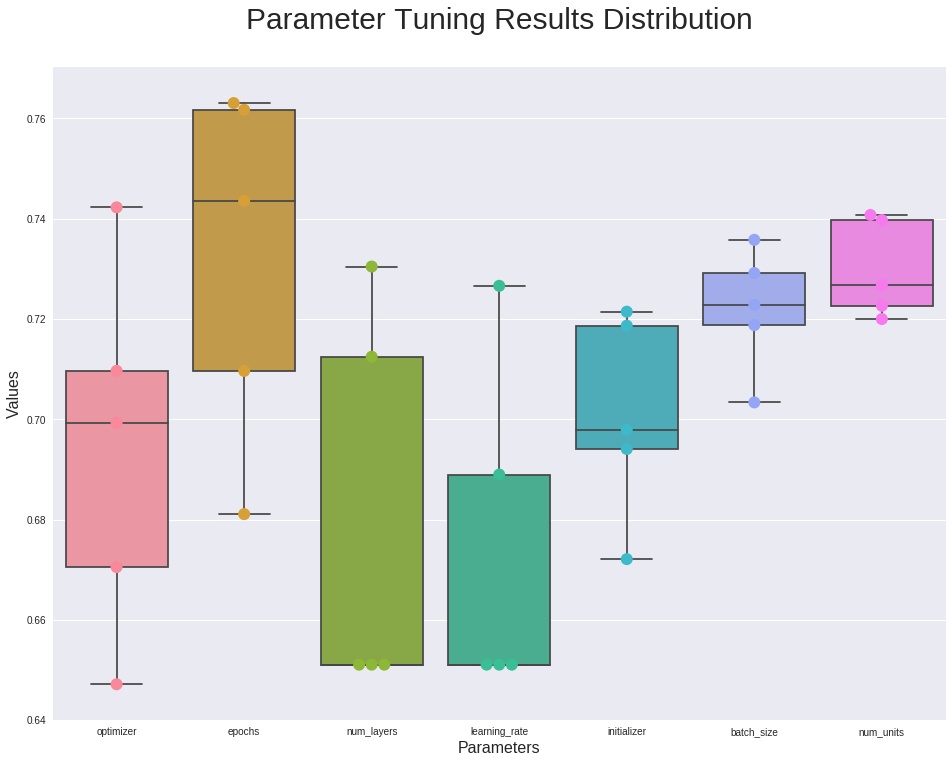

In [0]:
visualize_distribution(df, save_figure=True)

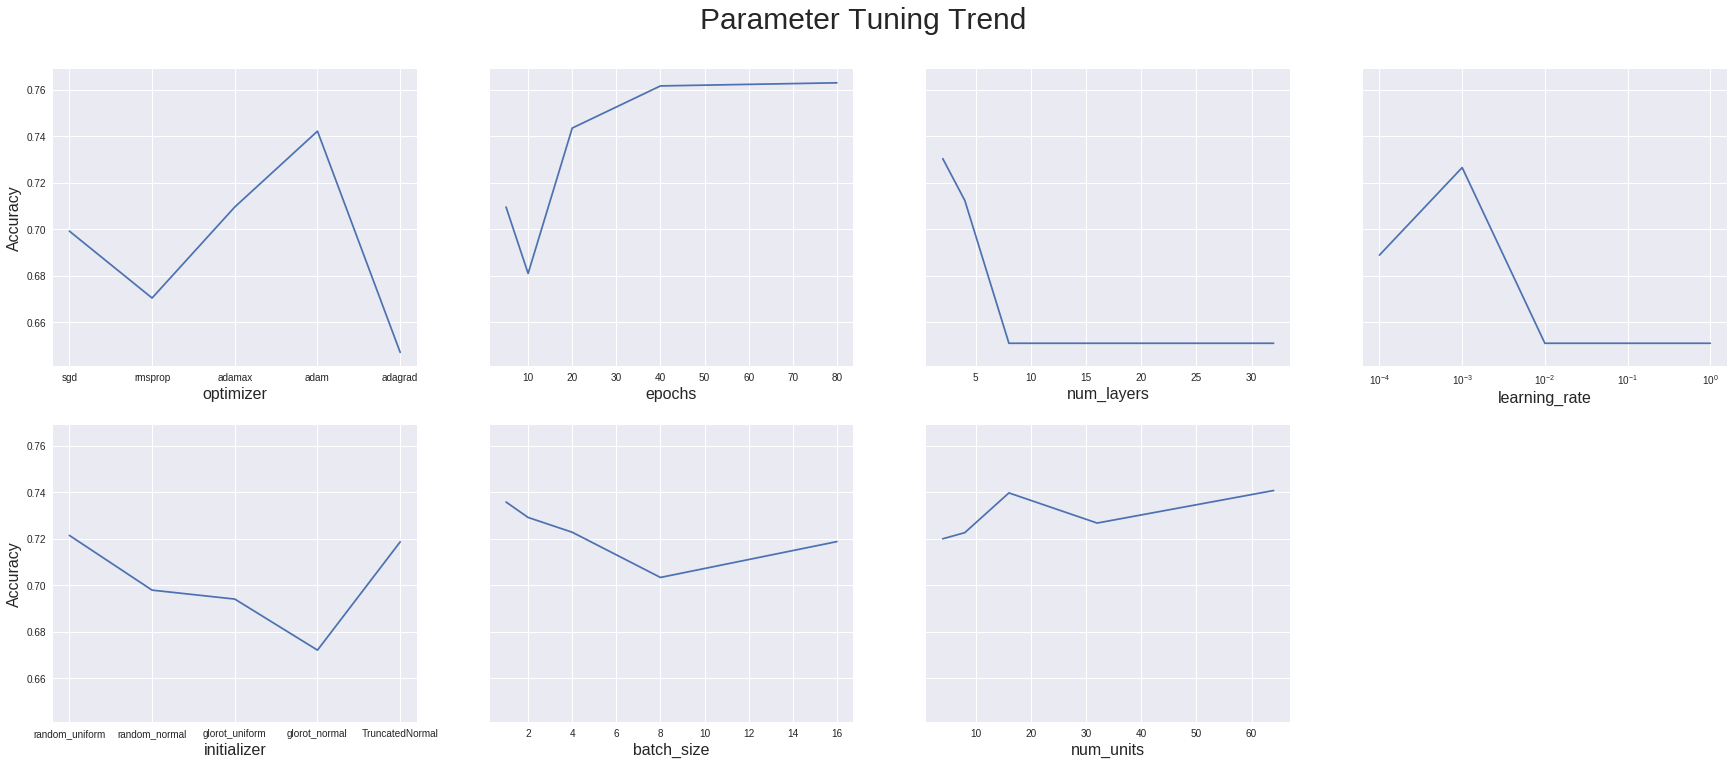

In [0]:
visualize_trend(df, save_figure=True)

In [0]:
best_options = get_best_options(df)
print(best_options)

for i in best_options:
  param_dict[i[0]] = i[1]
print(param_dict)

[['batch_size', 1], ['epochs', 80], ['initializer', 'random_uniform'], ['learning_rate', 0.001], ['num_layers', 2], ['num_units', 64], ['optimizer', 'adam']]
{'input_dim': 8, 'num_layers': 2, 'num_units': 64, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.001, 'metrics': ['accuracy'], 'epochs': 80, 'batch_size': 1, 'one_hot': False}


In [0]:
# Build a model using the best options
run_test(X=X, y=y, param_dict=param_dict)

Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 64, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.001, 'metrics': ['accuracy'], 'epochs': 80, 'batch_size': 1, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 49.3 mintues.
Mean Accuracy: 78.00%, Standard Deviation: 4.59%


0.7800239250705573

Wow, that's brutal - it took almost 50 minutes! But I guess I cannot complain since the result is great! Definitely close to top results for this dataset. Let's now try tuning individual parameters using the default parameter settings. First, start with learning rate.



In [0]:
# Get the default params
param_dict = get_defaults()

# Get 6 randomly generated learning rates between 0.0001 and 0.01
bases = np.repeat(10, 3)
exponents_1 = -(np.random.rand(3) + 3) # 3 from between 0.0001 and 0.001
exponents_2 = -(np.random.rand(3) + 2) # another 3 between 0.001 and 0.01

learning_rate = np.power(bases, exponents_1).tolist() + np.power(bases, exponents_2).tolist()

tuning_options = get_tuning_options(learning_rate=learning_rate)

results_lr = run_test(X=X, y=y,
                      param_dict=param_dict,
                      tuning_options=tuning_options)


Evaluating parameter "learning_rate" using value "0.0004828852547308251"...
Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.0004828852547308251, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 4, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 1.6 mintues.
Mean Accuracy: 72.14%, Standard Deviation: 5.85%

Evaluating parameter "learning_rate" using value "0.0006716184352348816"...
Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.0006716184352348816, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 4, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cr

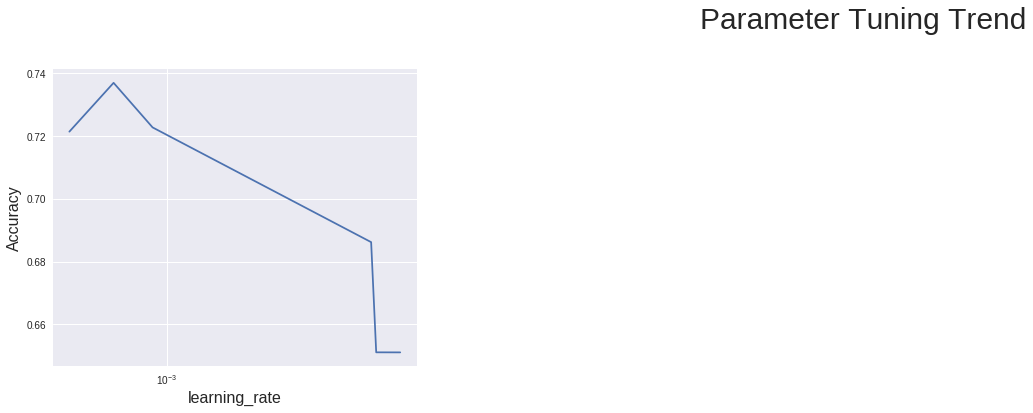

In [0]:
df_lr = wrangle_results(results_lr)
visualize_trend(df_lr)

In [0]:
best_lr = get_best_options(df_lr)
best_lr

[['learning_rate', 0.0006716184352348816]]

In [0]:
param_dict['learning_rate'] = best_lr[0][1]

run_test(X=X, y=y, param_dict=param_dict)

Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.0006716184352348816, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 4, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 1.6 mintues.
Mean Accuracy: 73.06%, Standard Deviation: 6.29%


0.7306220114964456

Let's check the baseline model and confirm the model above is indeed better:

In [0]:
accuracy_baseline

0.7161141519585621

Great! We have an alomost 2 percentage points improvement!

Next, let's keep the updated learning rate and tune batch size:

In [0]:
batch_size = [2 ** e for e in range(6)]

tuning_options = get_tuning_options(batch_size=batch_size)

results_batch = run_test(X=X, y=y, 
                         param_dict=param_dict, 
                         tuning_options=tuning_options)


Evaluating parameter "batch_size" using value "1"...
Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.0006716184352348816, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 1, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 6.0 mintues.
Mean Accuracy: 72.67%, Standard Deviation: 4.94%

Evaluating parameter "batch_size" using value "2"...
Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.0006716184352348816, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 2, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 3.1 mintues.
Mean Accuracy

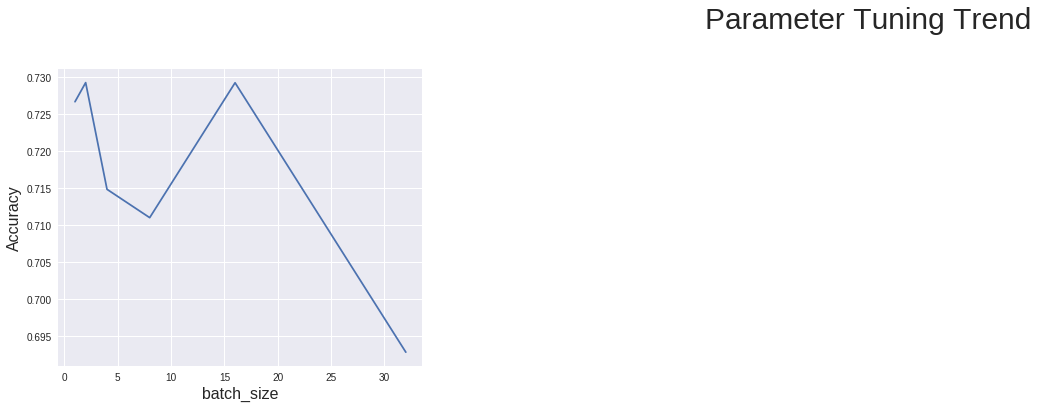

In [0]:
df_batch = wrangle_results(results_batch)
visualize_trend(df_batch)

Although batch size of 2 has a higher accuracy result, the time cost significantly outweighs the benefit, so we'll go with batch size of 16.

In [0]:
param_dict['batch_size'] = 16

run_test(X=X, y=y, param_dict=param_dict)

Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.0006716184352348816, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 16, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 0.5 mintues.
Mean Accuracy: 70.32%, Standard Deviation: 5.70%


0.7032296672351377

In [0]:
# Let's get the baseline accuracy to compare
accuracy_baseline

0.7161141519585621

This is weird... It's possible that due to randomness the result is not consistent. Wel'll still keep the best batch size and tune epochs.


Evaluating parameter "epochs" using value "40"...
Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.0006716184352348816, 'metrics': ['accuracy'], 'epochs': 40, 'batch_size': 16, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 1.7 mintues.
Mean Accuracy: 76.18%, Standard Deviation: 3.60%

Evaluating parameter "epochs" using value "60"...
Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.0006716184352348816, 'metrics': ['accuracy'], 'epochs': 60, 'batch_size': 16, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 2.5 mintues.
Mean Accuracy: 76

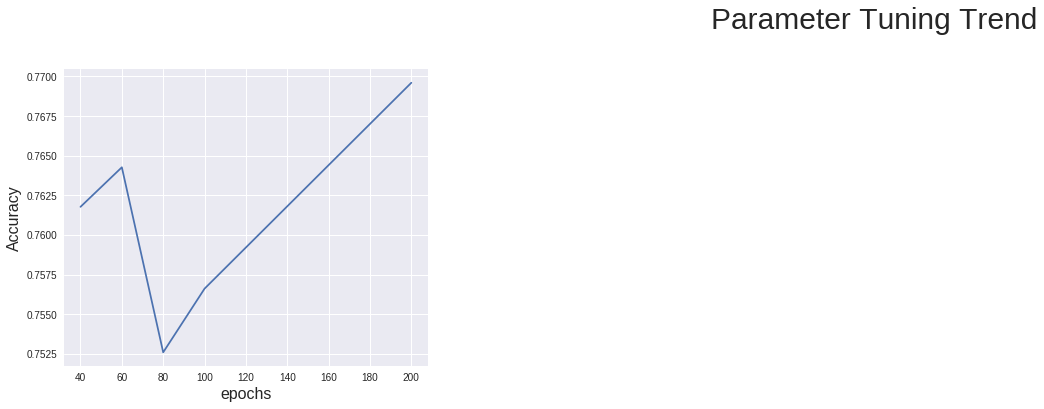

In [0]:
epochs = [40, 60, 80, 100, 150, 200] 

tuning_options = get_tuning_options(epochs=epochs)

results_epoch = run_test(X=X, y=y, 
                         param_dict=param_dict, 
                         tuning_options=tuning_options)

df_epoch = wrangle_results(results_epoch)
visualize_trend(df_epoch)

It seems the more epochs, the better the result is.

In [0]:
epochs = get_best_options(df_epoch)
param_dict['epochs'] = epochs[0][1]

Next, let's test whether standardizing the data is helpful. We'll first try with the baseline parameters.

In [0]:
run_test(X=X_std, y=y, param_dict=param_dict_defaults)

Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.001, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 4, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 1.7 mintues.
Mean Accuracy: 76.95%, Standard Deviation: 2.88%


0.769497609435901

Wow, incredible! That's 76.95% vs. 71.61%, a more than 5 percentage points increase without doing any tuning! Let's now use the best param options obtained so far and the standardized data to train a final model.

In [0]:
run_test(X=X_std, y=y, param_dict=param_dict)

Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.0006716184352348816, 'metrics': ['accuracy'], 'epochs': 200, 'batch_size': 16, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 8.3 mintues.
Mean Accuracy: 78.53%, Standard Deviation: 3.64%


0.7852699952588371

There we go! We have the [state-of-the-art accuracy result](https://www.kaggle.com/general/19387) now with 10-fold cross-validation! Although it seems parameter tuning's contribution in performance increase is marginal compared with data standardization.

## To-do's

- add dropout layer and regularization
- add time used in visualization